# Brain tumor classification

## Import libraries

In [7]:
# --- Basic imports ---
import os
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Sklearn ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier

# --- Classifiers ---
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# --- TensorFlow / Keras for feature extraction ---
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input


import joblib  # to save/load features
import pickle

## Base classifiers

In [8]:
# Define base classifiers
base_models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel='rbf', probability=True),
    "Decision Tree": DecisionTreeClassifier(max_depth=15, random_state=10),
    "Random Forest": RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=10)
}


## Feature Extraction (EfficientNetB0)

In [9]:
def extract_deep(img_path, model):
    """Extract EfficientNetB0 features from a single image."""
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feats = model.predict(x, verbose=0)
    return feats.flatten()  # flatten to 1D array


## Load Dataset and Deep Features

### Batch-wise Feature Extraction for Training

In [10]:
def load_training_features_batch(data_dir, batch_size=32, save_file="train_features.npz"):

    model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')
    train_dir = os.path.join(data_dir, 'Training')
    label_map = {label: idx for idx, label in enumerate(sorted(os.listdir(train_dir)))}

    X_list, y_list, paths_list = [], [], []

    for label, idx in label_map.items():
        folder = os.path.join(train_dir, label)
        if not os.path.exists(folder):
            continue
        files = sorted(os.listdir(folder))
        n_batches = math.ceil(len(files) / batch_size)

        for i in range(n_batches):
            batch_files = files[i*batch_size:(i+1)*batch_size]
            batch_imgs = []
            batch_paths = []
            for file in batch_files:
                img_path = os.path.join(folder, file)
                try:
                    img = image.load_img(img_path, target_size=(224, 224))
                    x = image.img_to_array(img)
                    x = preprocess_input(x)
                    batch_imgs.append(x)
                    batch_paths.append(img_path)
                except Exception as e:
                    print(f"Skipping {img_path}: {e}")
                    continue

            if batch_imgs:
                batch_array = np.array(batch_imgs, dtype=np.float32)
                feats = model.predict(batch_array, verbose=0)
                X_list.append(feats)
                y_list.extend([idx]*len(feats))
                paths_list.extend(batch_paths)

    # Combine all batches
    X = np.vstack(X_list).astype(np.float32)
    y = np.array(y_list, dtype=np.int32)

    # Save to disk
    np.savez_compressed(save_file, X=X, y=y, paths=paths_list, label_map=label_map)
    print(f"Saved training features to {save_file} | Shape: {X.shape}")

    return X, y, paths_list, label_map


### Testing Folder Batch-wise Extraction

In [ ]:
import streamlit as st
import numpy as np
import joblib
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
from datetime import datetime
import cv2

# --- Page Configuration ---
st.set_page_config(page_title="Brain Tumor Classifier", layout="wide")
st.title("Brain Tumor Classification")
st.markdown("---")

# --- Sidebar ---
st.sidebar.title("About")
st.sidebar.info("Upload a brain MRI image to classify using pre-trained ML models.")
st.sidebar.markdown("**Models Used:** KNN, SVM, Random Forest, Voting Classifier")

# --- Load Models and Scaler ---
try:
    knn_model = joblib.load("knn_model_final.pkl")
    svm_model = joblib.load("svm_model_final.pkl")
    rf_model = joblib.load("rf_model_final.pkl")
    voting_model = joblib.load("voting_model.pkl")
    scaler = joblib.load("scaler_final.pkl")
except Exception as e:
    st.error(f"Error loading models/scaler: {e}")
    st.stop()

models = {
    "KNN": knn_model,
    "SVM": svm_model,
    "Random Forest": rf_model,
    "Voting": voting_model
}

labels = {0: "glioma", 1: "meningioma", 2: "pituitary", 3: "notumor"}

# --- Load EfficientNetB0 ---
@st.cache_resource
def load_effnet():
    return EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')

eff_model = load_effnet()

# --- Feature Extraction ---
def extract_deep(img):
    img_resized = cv2.resize(img, (224, 224))
    x = image.img_to_array(img_resized)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feat = eff_model.predict(x, verbose=0)
    return feat.flatten()

# --- Upload Section ---
uploaded_file = st.file_uploader("Upload a Brain MRI Image", type=["jpg", "png", "jpeg"])

if uploaded_file:
    file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
    img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    col1, col2 = st.columns([1, 2])
    with col1:
        st.image(img_rgb, caption="Uploaded MRI", width=300)

    with col2:
        with st.spinner("Extracting features and predicting..."):
            features = extract_deep(img_rgb).reshape(1, -1)
            scaled_features = scaler.transform(features)

            predictions = {}
            agreement = {}

            for name, model in models.items():
                pred = model.predict(scaled_features)[0]
                label = labels[pred]
                predictions[name] = label
                agreement[label] = agreement.get(label, 0) + 1

            # Voting
            final_pred = max(agreement, key=agreement.get)
            vote_count = agreement[final_pred]

            st.success(f"Suggested Class: **{final_pred}** ({vote_count}/4 models agree)")

            with st.expander("View Individual Model Predictions", expanded=False):
                for name, pred_label in predictions.items():
                    st.markdown(f"**{name}:** {pred_label}")

            # Downloadable Report
            timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            report = f"""Brain Tumor Classification Report
Date: {timestamp}
Final Suggested Class: {final_pred}
Agreement: {vote_count}/4 models
Individual Predictions:
"""
            for name, pred_label in predictions.items():
                report += f"{name}: {pred_label}\n"

            st.download_button("📄 Download Prediction Report", data=report, file_name="tumor_prediction.txt", mime="text/plain")


### Load Training & Testing Features

In [12]:
data_dir = r"C:\Python\Brain Tumor\archive"

# Training
start = time.time()
X_train, y_train, paths_train, label_map = load_training_features_batch(data_dir, batch_size=32, save_file="train_features.npz")
end = time.time()
print(f"Training features loaded: {X_train.shape} in {end - start:.2f}s")

# Testing
start = time.time()
X_test_final, y_test_final, paths_test_final = load_testing_features_batch(data_dir, label_map, batch_size=32, save_file="test_features.npz")
end = time.time()
print(f"Testing features loaded: {X_test_final.shape} in {end - start:.2f}s")


Saved training features to train_features.npz | Shape: (5712, 1280)
Training features loaded: (5712, 1280) in 185.54s
Skipping C:\Python\Brain Tumor\archive\Testing\glioma\.ipynb_checkpoints: [Errno 13] Permission denied: 'C:\\Python\\Brain Tumor\\archive\\Testing\\glioma\\.ipynb_checkpoints'
Saved testing features to test_features.npz | Shape: (1311, 1280)
Testing features loaded: (1311, 1280) in 40.40s


## Baseline Model Training

In [13]:
# === Train/Validation Split on Training Folder ===
X_train_raw, X_val_raw, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=10)

In [14]:
# Fit scaler only on training split
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw.astype(np.float32))
X_val_scaled = scaler.transform(X_val_raw.astype(np.float32))

In [15]:
acc_baseline = {}
print("\n=== Baseline Evaluation on Validation Split ===")

for name, model in base_models.items():
    start = time.time()
    model.fit(X_train_scaled, y_train_split)
    y_pred_val = model.predict(X_val_scaled)
    elapsed = time.time() - start

    acc = accuracy_score(y_val_split, y_pred_val)
    acc_baseline[name] = acc

    print(f"\n{name} | Validation Accuracy: {acc:.4f} | Training Time: {elapsed:.2f}s")
    print(f"Classification Report - {name}:\n")
    print(classification_report(y_val_split, y_pred_val, target_names=label_map.keys()))


=== Baseline Evaluation on Validation Split ===


c:\Program Files\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Program Files\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Program Files\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Program Files\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Program Files\Python311\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi


KNN | Validation Accuracy: 0.9160 | Training Time: 0.21s
Classification Report - KNN:

              precision    recall  f1-score   support

      glioma       0.91      0.92      0.91       264
  meningioma       0.85      0.85      0.85       268
     notumor       0.98      0.91      0.94       319
   pituitary       0.92      0.98      0.95       292

    accuracy                           0.92      1143
   macro avg       0.91      0.92      0.91      1143
weighted avg       0.92      0.92      0.92      1143


SVM | Validation Accuracy: 0.9484 | Training Time: 32.58s
Classification Report - SVM:

              precision    recall  f1-score   support

      glioma       0.97      0.92      0.95       264
  meningioma       0.87      0.92      0.89       268
     notumor       0.98      0.97      0.97       319
   pituitary       0.97      0.98      0.97       292

    accuracy                           0.95      1143
   macro avg       0.95      0.95      0.95      1143
weighted

### Scale Full Training Folder for Final Testing

In [16]:
# Fit scaler on full Training folder
scaler_full = StandardScaler()
X_train_full_scaled = scaler_full.fit_transform(X_train.astype(np.float32))

# Scale Testing folder using same scaler
X_test_final_scaled = scaler_full.transform(X_test_final.astype(np.float32))


### Train on Full Training and Evaluate on Testing Folder

In [17]:
print("\n=== Final Evaluation on Testing Folder ===")

# Dictionary to store Testing accuracies
acc_testing = {}

for name, model in base_models.items():
    start = time.time()

    # Train on full Training folder
    model.fit(X_train_full_scaled, y_train)

    # Predict on Testing folder
    y_pred_test = model.predict(X_test_final_scaled)

    elapsed = time.time() - start
    acc_test = accuracy_score(y_test_final, y_pred_test)

    # Store for comparison table
    acc_testing[name] = acc_test

    print(f"\n{name} | Test Accuracy: {acc_test:.4f} | Training + Prediction Time: {elapsed:.2f}s")
    print(f"Classification Report - {name}:\n")
    print(classification_report(y_test_final, y_pred_test, target_names=label_map.keys()))



=== Final Evaluation on Testing Folder ===

KNN | Test Accuracy: 0.9306 | Training + Prediction Time: 0.15s
Classification Report - KNN:

              precision    recall  f1-score   support

      glioma       0.94      0.92      0.93       300
  meningioma       0.89      0.83      0.86       306
     notumor       0.96      0.97      0.97       405
   pituitary       0.92      0.99      0.95       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.93      0.93      0.93      1311


SVM | Test Accuracy: 0.9542 | Training + Prediction Time: 48.65s
Classification Report - SVM:

              precision    recall  f1-score   support

      glioma       0.98      0.86      0.92       300
  meningioma       0.87      0.94      0.91       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.98      1.00      0.99       300

    accuracy                           0.95      1311
   m

## Visualization

### Accuracy Comparison

In [18]:
# Validation accuracy from baseline
val_acc = {model: acc_baseline[model] for model in base_models}

# Testing folder accuracy
test_acc = {model: acc_testing[model] for model in base_models}

# Create DataFrame
comparison_df = pd.DataFrame({
    "Validation Accuracy": val_acc,
    "Testing Accuracy": test_acc
})

print("\n=== Accuracy Comparison Table ===")
print(comparison_df)



=== Accuracy Comparison Table ===
               Validation Accuracy  Testing Accuracy
KNN                       0.916010          0.930587
SVM                       0.948381          0.954233
Decision Tree             0.780402          0.832952
Random Forest             0.914261          0.932876


### Accuracy comparison plot

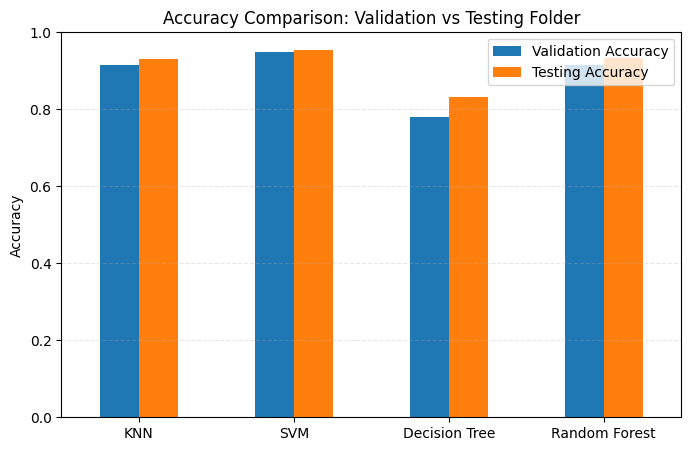

In [19]:
comparison_df.plot(kind='bar', figsize=(8,5))
plt.title("Accuracy Comparison: Validation vs Testing Folder")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()


### Confusion Matrix


=== Confusion Matrices on Testing Folder ===


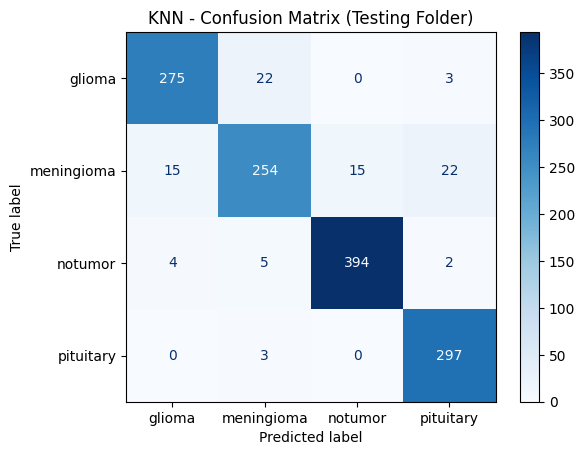

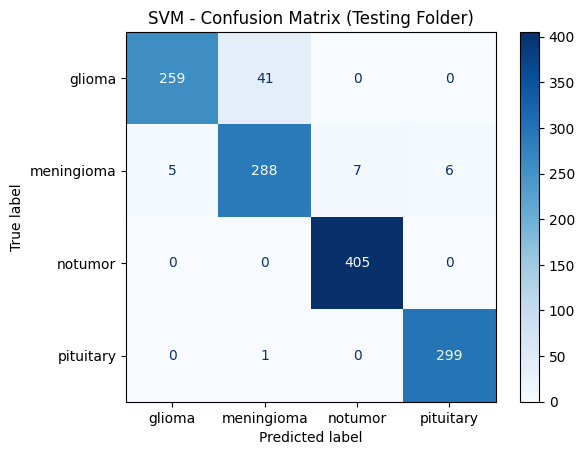

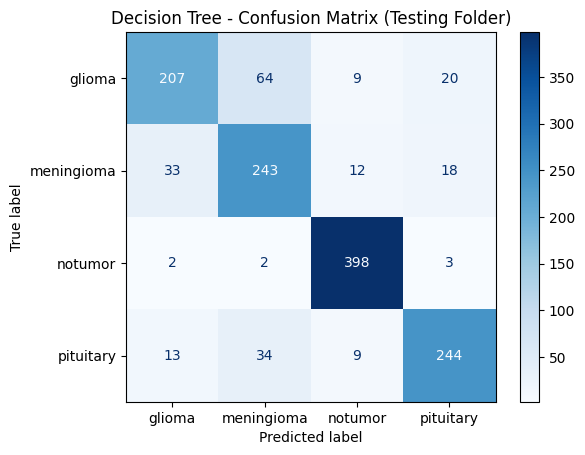

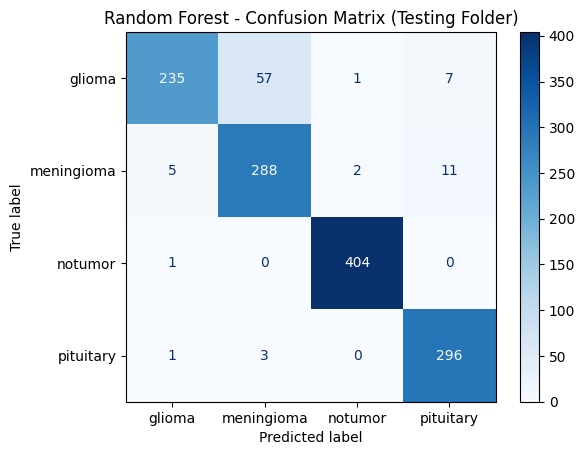

In [20]:

print("\n=== Confusion Matrices on Testing Folder ===")

for name, model in base_models.items():
    # Predict on Testing folder
    y_pred_test = model.predict(X_test_final_scaled)

    # Compute confusion matrix
    cm = confusion_matrix(y_test_final, y_pred_test)

    # Display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map.keys())
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='horizontal')
    plt.title(f"{name} - Confusion Matrix (Testing Folder)")
    plt.show()


# Hyper parameter tuning

### Hyperparameter tuning using GridSearchCV

In [21]:
param_grids = {
    "KNN": {
        "n_neighbors": [5],
        "weights": ["uniform", "distance"],
        'metric': ['euclidean', 'manhattan']
    },
    "SVM": {
        "C": [10],
        "kernel": ["rbf"],
        "gamma": ["scale", "auto"]
    },
    "Decision Tree": {
        "max_depth": [10, 20],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    },
    "Random Forest": {
        "n_estimators": [150,200],
        "max_depth": [10, 20],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    }
}


In [22]:
best_models = {}  # Store best models after tuning

for name, model in base_models.items():
    print(f"\n=== Running GridSearchCV for {name} ===")

    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring="accuracy",
        cv=5,
        n_jobs=-1,  # use all cores
        verbose=1
    )

    grid.fit(X_train_full_scaled, y_train)  # full training features

    print(f"Best Params for {name}: {grid.best_params_}")
    print(f"Best CV Accuracy for {name}: {grid.best_score_:.4f}")

    best_models[name] = grid.best_estimator_



=== Running GridSearchCV for KNN ===
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Params for KNN: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best CV Accuracy for KNN: 0.8978

=== Running GridSearchCV for SVM ===
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Params for SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best CV Accuracy for SVM: 0.9391

=== Running GridSearchCV for Decision Tree ===
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Params for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best CV Accuracy for Decision Tree: 0.7547

=== Running GridSearchCV for Random Forest ===
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Params for Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best CV Accuracy for Random Forest: 0.8678


### run models with best params

In [23]:
knn_best = KNeighborsClassifier(metric='manhattan', n_neighbors=5, weights='distance')

svm_best = SVC(C=10, gamma='auto', kernel='rbf', probability=True)

dt_best = DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=2, random_state=42)

rf_best = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_leaf=1, min_samples_split=5, random_state=10)

In [24]:
best_models = {
    "KNN": knn_best,
    "SVM": svm_best,
    "Decision Tree": dt_best,
    "Random Forest": rf_best
}


=== Final Evaluation of Best Models on Testing Folder ===

KNN | Test Accuracy: 0.9710 | Training + Inference Time: 0.89s
Classification Report - KNN:

              precision    recall  f1-score   support

      glioma       0.99      0.92      0.95       300
  meningioma       0.92      0.96      0.94       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



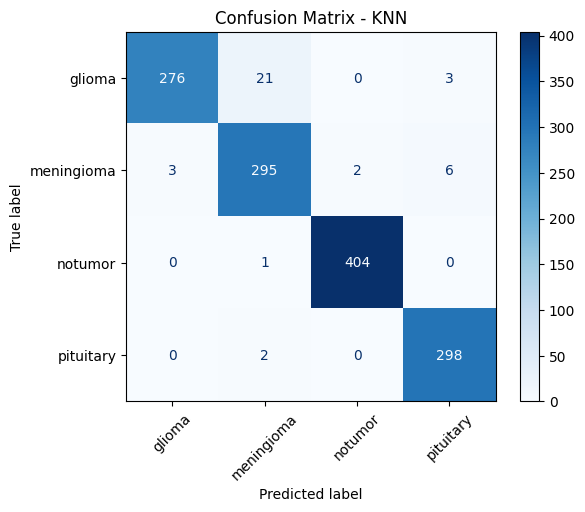


SVM | Test Accuracy: 0.9832 | Training + Inference Time: 50.80s
Classification Report - SVM:

              precision    recall  f1-score   support

      glioma       1.00      0.94      0.97       300
  meningioma       0.94      0.99      0.96       306
     notumor       0.99      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



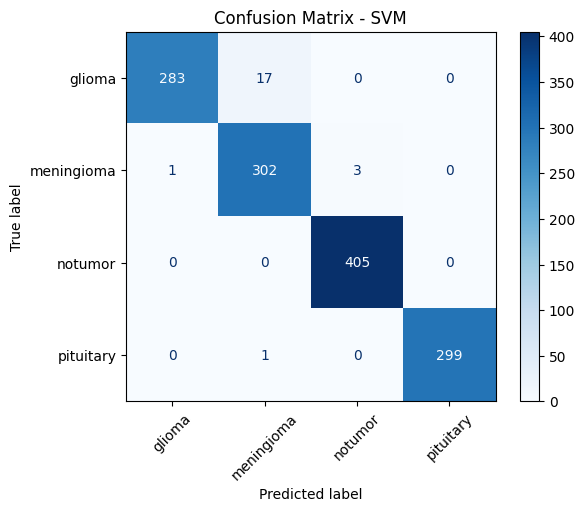


Decision Tree | Test Accuracy: 0.8284 | Training + Inference Time: 6.40s
Classification Report - Decision Tree:

              precision    recall  f1-score   support

      glioma       0.79      0.72      0.75       300
  meningioma       0.71      0.76      0.73       306
     notumor       0.94      0.97      0.95       405
   pituitary       0.85      0.82      0.83       300

    accuracy                           0.83      1311
   macro avg       0.82      0.82      0.82      1311
weighted avg       0.83      0.83      0.83      1311



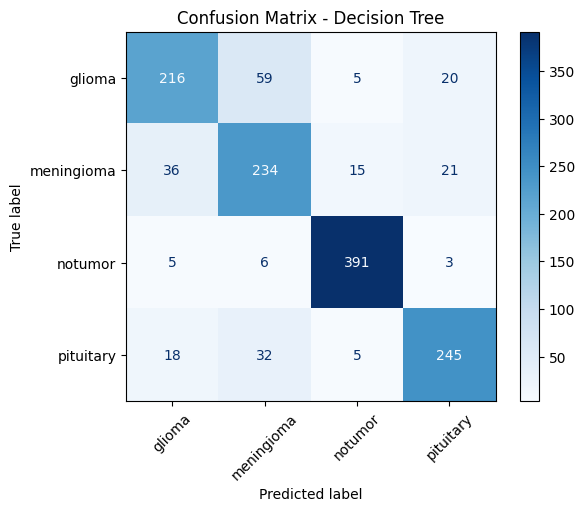


Random Forest | Test Accuracy: 0.9336 | Training + Inference Time: 33.18s
Classification Report - Random Forest:

              precision    recall  f1-score   support

      glioma       0.96      0.80      0.87       300
  meningioma       0.84      0.92      0.88       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.93      0.99      0.96       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.94      0.93      0.93      1311



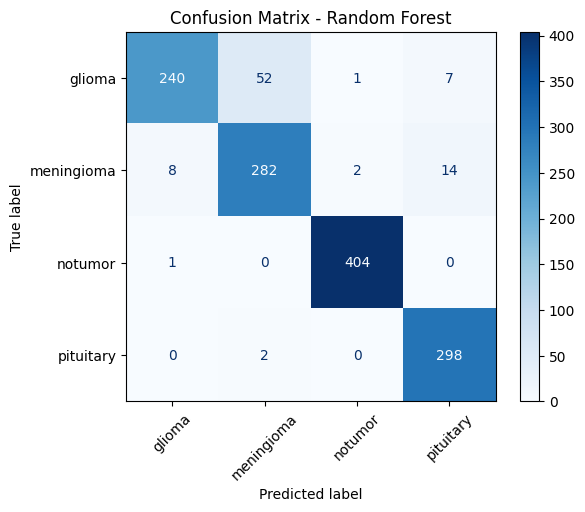

In [25]:
# === Evaluate on Testing Folder ===
acc_testing = {}

print("\n=== Final Evaluation of Best Models on Testing Folder ===")
for name, model in best_models.items():
    start = time.time()
    model.fit(X_train_full_scaled, y_train)  # train on all training data
    y_pred_test = model.predict(X_test_final_scaled)
    elapsed = time.time() - start

    acc = accuracy_score(y_test_final, y_pred_test)
    acc_testing[name] = acc

    print(f"\n{name} | Test Accuracy: {acc:.4f} | Training + Inference Time: {elapsed:.2f}s")
    print(f"Classification Report - {name}:\n")
    print(classification_report(y_test_final, y_pred_test, target_names=label_map.keys()))

    # Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test_final, y_pred_test), display_labels=label_map.keys())
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

### Compare Accuracy (Non-tuned vs Tuned) on Testing folder

In [29]:
acc_testing_non_tuned = {
    "KNN": 0.930587,
    "SVM": 0.954233,
    "Decision Tree": 0.832952,
    "Random Forest": 0.932876
}

acc_testing_tuned = {
    "KNN": 0.9710,
    "SVM": 0.9832,
    "Decision Tree": 0.8284,
    "Random Forest": 0.9336
}

# --- Create comparison DataFrame ---
accuracy_comparison_df = pd.DataFrame({
    "Non-Tuned Accuracy": acc_testing_non_tuned,
    "Tuned Accuracy": acc_testing_tuned
})

# Optional: round values
accuracy_comparison_df = accuracy_comparison_df.round(4)

print("\n=== Accuracy Comparison: Non-Tuned vs Tuned Models ===")
print(accuracy_comparison_df)



=== Accuracy Comparison: Non-Tuned vs Tuned Models ===
               Non-Tuned Accuracy  Tuned Accuracy
KNN                        0.9306          0.9710
SVM                        0.9542          0.9832
Decision Tree              0.8330          0.8284
Random Forest              0.9329          0.9336


## Voting classifier

In [30]:

# --- Build Voting Classifier---
voting_clf = VotingClassifier(
    estimators=[
        ("knn", knn_best),
        ("svm", svm_best),
        ("rf", rf_best)
    ],
    voting="soft"
)

# Fit on full training data
voting_clf.fit(X_train_full_scaled, y_train)

# Evaluate on test set
y_pred_voting = voting_clf.predict(X_test_final_scaled)
acc_voting = accuracy_score(y_test_final, y_pred_voting)

print(f"\nVoting Classifier Accuracy on Test Set: {acc_voting:.4f}")
print("\nClassification Report (Voting Classifier):")
print(classification_report(y_test_final, y_pred_voting, target_names=label_map.keys()))



Voting Classifier Accuracy on Test Set: 0.9840

Classification Report (Voting Classifier):
              precision    recall  f1-score   support

      glioma       1.00      0.95      0.97       300
  meningioma       0.95      0.99      0.97       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      1.00      1.00       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



Text(0.5, 1.0, 'Confusion Matrix')

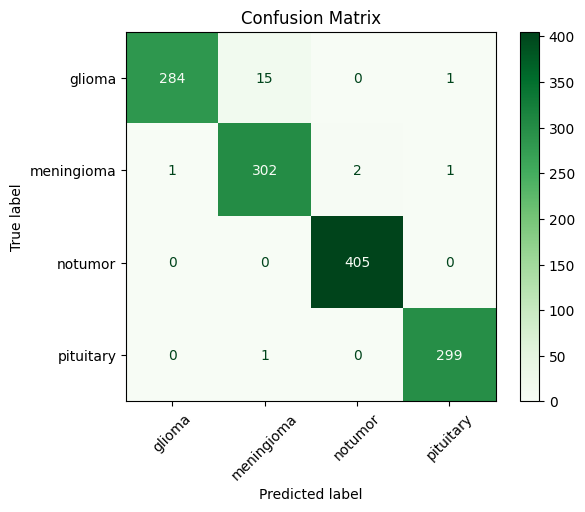

In [34]:
ConfusionMatrixDisplay(confusion_matrix(y_test_final, y_pred_voting), display_labels=label_map.keys()).plot(cmap=plt.cm.Greens, xticks_rotation=45)
plt.title(f"Confusion Matrix")

## Save best models

In [31]:
# --- Save all models for deployment ---
joblib.dump(knn_best, "knn_model_final.pkl")
joblib.dump(svm_best, "svm_model_final.pkl")
joblib.dump(rf_best, "rf_model_final.pkl")
joblib.dump(voting_clf, "voting_model.pkl")

# --- Save the scaler ---
joblib.dump(scaler, "scaler_final.pkl")

print("\nModels and scaler saved: knn_model_final.pkl, svm_model_final.pkl, rf_model_final.pkl, voting_model.pkl, scaler_final.pkl")



Models and scaler saved: knn_model_final.pkl, svm_model_final.pkl, rf_model_final.pkl, voting_model.pkl, scaler_final.pkl
